# Fourier Neural Operator - Navier Stokes 2D

In this notebook we'll train the Fourier Neural Operator for 2D equations. We'll use the Navier Stokes equation as an example.

The Navier Stokes equation is given by

$$
\begin{align*}
\partial_t w(x,t) + u(x,t) \cdot \nabla w(x,t) &= \nu \Delta w(x,t) + f(x)\\
\nabla \cdot u(x,t) &= 0\\
w(x,0) &= w_0(x)
\end{align*}
$$

where $w(x,t)$ is the velocity field, $u(x,t)$ is the vortex field, $\nu$ is the viscosity, and $f(x)$ is the forcing term.

## Libraries

In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

# Numpy
import numpy as np

# Scipy
import scipy.io

# h5py for loading mat file
import h5py

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc

# IPython for displaying the animation
from IPython.display import HTML
rc('animation', html='jshtml')

# itertools for iterating through the list
from itertools import islice as take

# Tqdm for the progress bar
from tqdm import trange

# Set the random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print GPUs device name
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print("GPU",i,":",torch.cuda.get_device_name(i))

GPU 0 : NVIDIA GeForce RTX 3050 Laptop GPU


## Utilities

We need to define some utilities such as MATLAB file reader.

In [2]:
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

## Fourier Neural Operator

Now we can define the Fourier Neural Operator.

### 3D Fourier convolution neural network

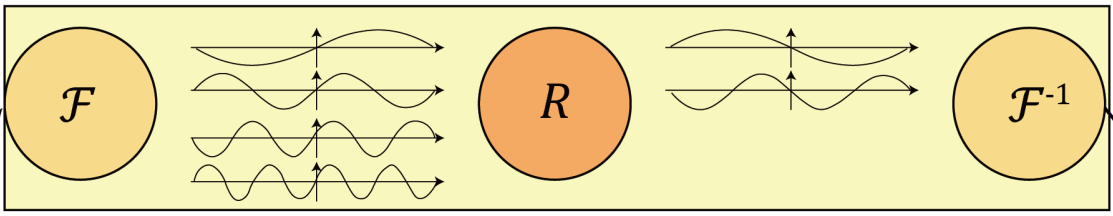

$$(R\cdot (\mathcal{F}v_t))_{k,l} = \sum_{j=i}^{d_v}R_{k,l,j}(\mathcal{F}v_t)_k,j$$

$$(\mathcal{K}(\phi)v_t)(x) = \mathcal{F}^{-1}\left((R\cdot (\mathcal{F}v_t\right)(x)$$

In [3]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # 2 modes per dimension max, i.e. 6 modes
        self.modes = modes  
    
        # Scale used to initialize weights
        self.scale = (1 / (in_channels * out_channels))
        
        # Weights for different convolution operations in Fourier space
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        
    def complex_multi_3D(self, inputs, weights):
        # Complex multiplication between inputs and weights
        return torch.einsum("bixyz,ioxyz->boxyz", inputs, weights)
    
    def forward(self, x):
        batchsize = x.shape[0]
        
        # Calculating the Fourier coefficients, i.e. applying FFT to x and swapping the order of dimensions
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])
        
        # Initialize output tensor in Fourier space with the following dimension [batch, out, x[-3], x[-2], x[-1]/2]
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        # Multiply the relevant Fourier modes with the corresponding weights
        out_ft[:, :, :self.modes, :self.modes, :self.modes] = self.complex_multi_3D(x_ft[:, :, :self.modes, :self.modes, :self.modes], self.weights1)
        
        out_ft[:, :, -self.modes:, :self.modes, :self.modes] = self.complex_multi_3D(x_ft[:, :, -self.modes:, :self.modes, :self.modes], self.weights2)
        
        out_ft[:, :, :self.modes, -self.modes:, :self.modes] = self.complex_multi_3D(x_ft[:, :, :self.modes, -self.modes:, :self.modes], self.weights3)

        out_ft[:, :, -self.modes:, -self.modes:, :self.modes] = self.complex_multi_3D(x_ft[:, :, -self.modes:, -self.modes:, :self.modes], self.weights4)
        
        
        # Calculate the inverse Fourier transform to get the final output in real space
        result = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return result

### Fourier Block Neural Network
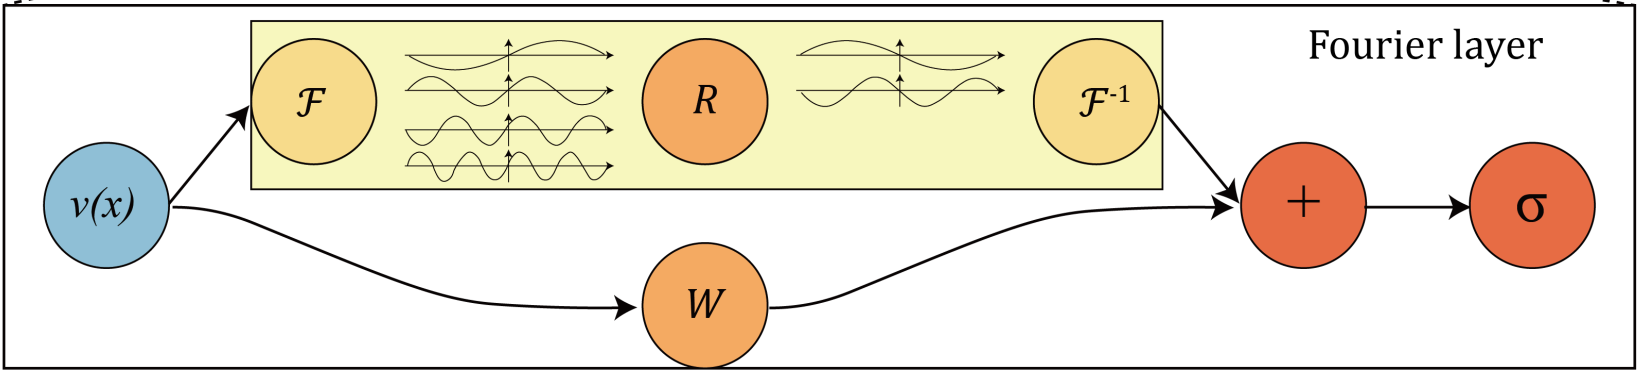
$$\sigma\left(Wv_t(x)+(\mathcal{K}(a,\phi)v_t)(x)\right)$$

where $W$ is a linear operator, $a$ is a vector of learnable parameters, $\phi$ is a vector of learnable parameters, and $\sigma$ is a non-linear activation function.

In [4]:
class FourierLayerBlock(nn.Module):
    def __init__(self, modes, width):
        super(FourierLayerBlock, self).__init__()
        self.modes = modes
        self.width = width
        
        # 3D Fourier Spectral Convolution Layer
        self.rama_superior = SpectralConv3d(self.width, self.width, self.modes)
        
        # 1D Convolution Layer
        self.rama_inferior = nn.Conv1d(self.width, self.width, 1)
        
    def forward(self, x, batchsize, size_x, size_y, size_z):
        # Forward pass in the upper branch (3D Fourier Spectral Convolution Layer)
        x_sup = self.rama_superior(x)
        
        # Forward pass in the lower branch (1D Convolution Layer) (W)
        x_inf = self.rama_inferior(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        
        # Sum the outputs of both branches and apply a ReLU activation function
        x = x_sup + x_inf # (+)
        x = F.relu(x) # (𝜎)
        return x

### 3D Fourier Neural Operator

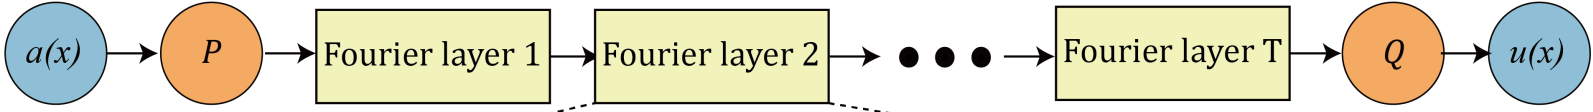

is the 3D Fourier Neural Operator. 3 dimensions are $x$, $y$, and $t$.

In [5]:
class FNO3D(nn.Module):
    def __init__(self, modes, width, layers=4):
        super(FNO3D, self).__init__()
        self.modes = modes
        self.width = width
        self.layers = layers
        self.S = 0
        self.T = 0
        
        # Input layer (P) [batch, sample, x, y, t]
        self.fc0 = nn.Linear(13, self.width)
        
        # Array of Fourier layer blocks
        self.module = nn.ModuleList()
        for idx in range(self.layers):
            fl = FourierLayerBlock(self.modes, self.width)
            self.module.append(fl)
        
        # Linear layers (Q)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        batchsize, S, _, T = x.shape
        if self.S != S or self.T != T:
            self.set_grid(x)
        x = x.reshape(batchsize,S,S,1,T).repeat([1,1,1,T,1])
        x = torch.cat((self.gridx.repeat([batchsize,1,1,1,1]), 
                       self.gridy.repeat([batchsize,1,1,1,1]), 
                       self.gridt.repeat([batchsize,1,1,1,1]), 
                       x), 
                      dim=-1)
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]
        
        # Forward pass through the input layer (P)
        x = self.fc0(x)
        # Swap the indices so that we have [batch, sample, x, y, t]
        x = x.permute(0, 4, 1, 2, 3) 
        
        # Forward pass through Fourier layer blocks
        for mod in self.module:
            x = mod(x, batchsize, size_x, size_y, size_z)
            
        # Linear layers and ReLU activation functions
        # Swap the indices so that we have [batch, sample, x, y, t]
        x = x.permute(0, 2, 3, 4, 1) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def set_grid(self, x):
        _, self.Sx, self.Sy, self.T = x.shape
        self.gridx = torch.tensor(np.linspace(0, 1, self.Sx), dtype=torch.float, device=x.device).reshape(1, self.Sx, 1, 1, 1).repeat([1, 1, self.Sy, self.T, 1])
        self.gridy = torch.tensor(np.linspace(0, 1, self.Sy), dtype=torch.float, device=x.device).reshape(1, 1, self.Sy, 1, 1).repeat([1, self.Sx, 1, self.T, 1])
        self.gridt = torch.tensor(np.linspace(0, 1, self.T+1)[1:], dtype=torch.float, device=x.device).reshape(1, 1, 1, self.T, 1).repeat([1, self.Sx, self.Sy, 1, 1])

## Loss Function

In [6]:
# Loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        # Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

## Training

### Data preparation

We'll train the model with pre-generated data. We'll use the Navier Stokes data with the following parameters:

- `visc = 1e-5`
- `tmax = 20`
- `x = 64`
- `y = 64`
- `n = 1200`

In [19]:
# Set path to data file
data_path = './NavierStokes_V1e-5_N1200_T20.mat'

# Read MATLAB file
reader = MatReader(data_path)

# Set number of examples to train and test
ntrain = 1000
ntest = 200

# Set batch size
batch_size = 10

# Get size of input/output
n, sx, sy, t = reader.read_field('u').shape

# Set Time to train
T_in = 10

# Set Time to predict
T_pred = 20 - T_in

# Set number of examples to train and test
ntrain = int(ntrain*0.8)
neval = int(ntrain*0.2)

# Get data to train
train_a = reader.read_field('u')[:ntrain,:, :,:T_in]
train_u = reader.read_field('u')[:ntrain,:, :,T_in:T_in+T_pred]

# Get data to evaluate
eval_a = reader.read_field('u')[ntrain:ntrain+neval,:, :,:T_in]
eval_u = reader.read_field('u')[ntrain:ntrain+neval,:, :,T_in:T_in+T_pred]

# Create data loaders for training and evaluation
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(eval_a, eval_u), batch_size=batch_size, shuffle=False)

### Functions for training

#### Function to train an epoch

In [8]:
def train_epoch(dataloader, model, optimizer, scheduler, loss_function):
    
    # Train for each batch
    for x, y in dataloader:
        out = model(x.to(device)).view(batch_size, sx, sy, T_pred)
        
        # Compute loss
        mse = F.mse_loss(out.view(batch_size, -1), y.to(device).view(batch_size, -1), reduction='mean')
        l2 = loss_function(out.view(batch_size, -1), y.to(device).view(batch_size, -1))

        # Clear gradients
        optimizer.zero_grad()

        # Backpropagation
        l2.backward() # l2 pérdida relativa

        # Update weights
        optimizer.step()

    scheduler.step()
    model.eval()

#### Function to evaluate an epoch

In [9]:
def eval_epoch(dataloader, model, loss_function, num_batches=None):
    # Freeze model parameters
    with torch.no_grad():
        # Historiales
        losses, mses = [], []
        
        # Evaluates this epoch with num_batches
        test_l2 = 0
        for a, u_true in take(dataloader, num_batches):
            out = model(a.to(device)).view(batch_size, sx, sy, T_pred)
            
            # Evaluamos con las funciones de perdida
            test_l2 = loss_function(out.view(1, -1), u_true.to(device).view(1, -1)).item()
            test_mse = F.mse_loss(out.view(1, -1), u_true.to(device).view(1, -1), reduction='mean')
            losses.append(test_l2)
            mses.append(test_mse.cpu())
            
        # Get mean loss and mean mse
        loss = np.mean(losses)
        mse = np.mean(mses)
        
        return loss, mse

#### Function to train the model

In [14]:
def train_model(model, train_dataloader, test_dataloader, lr=1e-3, epochs=20, scheduler_step=100, scheduler_gamma=0.05, train_batches=None, test_batches=None):
    # Función de pérdida
    loss_function = LpLoss(size_average=False)
    # loss_function = torch.nn.L1Loss()
    
    # Usamos al optimizador Adam
    # opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Usamos el scheduler StepLR para reducir de manera constante el learning rate después de ciertos pasos
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=scheduler_step, gamma=scheduler_gamma)
    
    # Inicializamos los historiales
    loss_hist, mse_hist = [], []
    
    # Entrenamos
    for epoch in trange(epochs):
        
        # Entrenamos la época
        train_epoch(train_dataloader, model, opt, scheduler, loss_function)

        # Evaluamos la época en entrenamiento
        trn_loss, trn_mse = eval_epoch(train_dataloader, model, loss_function, train_batches)
        
        # Evaluamos la época en prueba
        tst_loss, tst_mse = eval_epoch(test_dataloader, model, loss_function, test_batches)

        # Guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        mse_hist.append([trn_mse, tst_mse])
        
    return loss_hist, mse_hist

### Training the model

In [20]:
# Create model
model = FNO3D(modes=6, width=20).to(device)

In [21]:
# Train model
loss_hist, mse_hist = train_model(model, train_loader, eval_loader, lr=1e-3, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [25:27<00:00, 15.28s/it]


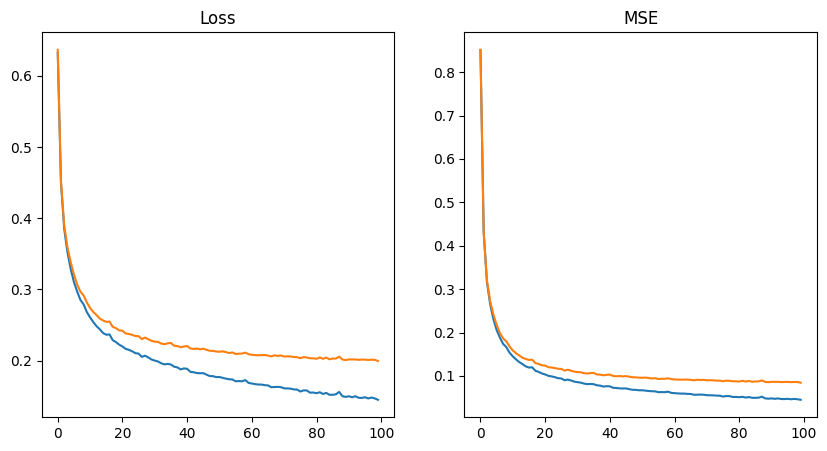

In [18]:
# Separate train and test loss as well as train and test mse
train_loss_hist = [loss[0] for loss in loss_hist]
test_loss_hist = [loss[1] for loss in loss_hist]
train_mse_hist = [mse[0] for mse in mse_hist]
test_mse_hist = [mse[1] for mse in mse_hist]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_loss_hist, label='Train')
ax[0].plot(test_loss_hist, label='Test')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(train_mse_hist, label='Train')
ax[1].plot(test_mse_hist, label='Test')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()